# Installing Modules

In [1]:
# Installing Modules
!pip install wandb -qU
!pip install pytorch_lightning



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.2 MB/s eta 0:00:00


# Drive Mount

In [2]:

# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importing Modules


In [3]:
# Importing Modules

import wandb
import torch 
import pytorch_lightning as pl
import torch.nn as nn
from torch.nn  import functional
from pytorch_lightning.loggers import WandbLogger
from matplotlib.font_manager import FontProperties
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import random
import csv
import pandas as pd
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt




# Unzip data

In [4]:
#Unzip aksharantar_sampled data 
!unzip /content/drive/MyDrive/dl/aksharantar_sampled.zip
# !unzip Tiro_Devanagari_Hindi.zip -d hindi

Archive:  /content/drive/MyDrive/dl/aksharantar_sampled.zip
   creating: aksharantar_sampled/
   creating: aksharantar_sampled/asm/
  inflating: aksharantar_sampled/asm/asm_test.csv  
  inflating: aksharantar_sampled/asm/asm_train.csv  
  inflating: aksharantar_sampled/asm/asm_valid.csv  
   creating: aksharantar_sampled/ben/
  inflating: aksharantar_sampled/ben/ben_test.csv  
  inflating: aksharantar_sampled/ben/ben_train.csv  
  inflating: aksharantar_sampled/ben/ben_valid.csv  
   creating: aksharantar_sampled/brx/
  inflating: aksharantar_sampled/brx/brx_test.csv  
  inflating: aksharantar_sampled/brx/brx_train.csv  
  inflating: aksharantar_sampled/brx/brx_valid.csv  
   creating: aksharantar_sampled/guj/
  inflating: aksharantar_sampled/guj/guj_test.csv  
  inflating: aksharantar_sampled/guj/guj_train.csv  
  inflating: aksharantar_sampled/guj/guj_valid.csv  
   creating: aksharantar_sampled/hin/
  inflating: aksharantar_sampled/hin/hin_test.csv  
  inflating: aksharantar_sampled

# Connecting Wandb


In [ ]:
# Connecting to Wandb
# wandb.login(key="8d6c17aa48af2229c26cbc16513ef266358c0b96")
# wandb.init(project="Assignment-02")


# Data Loading

In [5]:
lang = "hin" # name of the lang to train the model
base_dir = "aksharantar_sampled/" # root dir containing all the lang datasets

base_dir = base_dir+lang+"/" 
# hindi_font = FontProperties(fname = 'hindi/TiroDevanagariHindi-Regular.ttf')

train_file = base_dir+lang+"_train.csv"
val_file = base_dir+lang+"_valid.csv"
test_file = base_dir+lang+"_test.csv"

# loading train,valid,test csv files
train_data = pd.read_csv(train_file,header=None)
val_data = pd.read_csv(val_file,header=None)
test_data = pd.read_csv(test_file,header=None)


# Initialization of special tokens in Character dictionaries
latin_chars = {'<PAD>': 0, '<UNK>': 1,'<start>':2,'<end>':3}
lang_chars = {'<PAD>': 0, '<UNK>': 1,'<start>':2,'<end>':3}
latin_chars_num = {}
lang_chars_num = {}

# Character counting and numbering
for word in train_data[0]:
  for char in word :
    if char not in latin_chars:
      latin_chars[char] = len(latin_chars)

for word in train_data[1]:
  for char in word :
    if char not in lang_chars:
      lang_chars[char] = len(lang_chars)

# Reverse dictionaries
for key,value in latin_chars.items():
  latin_chars_num[value] = key

for key,value in lang_chars.items():
  lang_chars_num[value] = key

# Maximum word length
latin_max_length = len(max(train_data[0],key = len))
lang_max_length = len(max(train_data[1],key = len))

In [6]:
#Device selection
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def word_to_vec(data):
  data1= data.T
  data_pairs = []
  for i in range(0,len(data)):  # Iterating over data
    # Encoding words
    word =  [2]+[latin_chars.get(char,latin_chars['<UNK>']) for char in data1[i][0]] + [0]*(latin_max_length - len(data1[i][0]))+[3]
    word = word[:latin_max_length+2]
    latin_tensor = torch.tensor(word).to(device)
    word =  [2]+[lang_chars.get(char,lang_chars['<UNK>']) for char in data1[i][1]] + [0]*(lang_max_length - len(data1[i][1]))+[3]
    lang_tensor = torch.tensor(word).to(device)
    # Building data pairs
    data_pairs.append([latin_tensor,lang_tensor])
  # Returning data pairs
  return data_pairs 

# DataLoader

In [7]:
# Conversion to Encoded word pairs
train_data_pairs = word_to_vec(train_data)
val_data_pairs = word_to_vec(val_data)
test_data_pairs = word_to_vec(test_data)

# Data loaders and Batch size and shuffling
train_dataloader = DataLoader(train_data_pairs, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data_pairs, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data_pairs, batch_size=64, shuffle=False)


# Encoder

In [ ]:
class Encoder(nn.Module):
  ''' This is the model class used to define the Encoder structure and to train the neural network on given parameters'''
  def __init__(self,input_size,embedding_size,hidden_size,layers,cell_type,bidirectional,dropout):
    '''
      input_size: The size of the input vocabulary or the number of distinct tokens.
      embedding_size: The size of the embedding vectors for each token.
      hidden_size: The size of the hidden state of the RNN cell.
      layers: The number of layers in the RNN.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      bidirectional: A boolean flag indicating whether the RNN is bidirectional or not.
      dropout: The dropout probability for the RNN layers
    '''
    super(Encoder,self).__init__()
    self.cell_type = cell_type
    self.embedding = nn.Embedding(input_size,embedding_size)
    self.rnn = cell_type(embedding_size,hidden_size,layers,bidirectional = bidirectional,dropout=dropout)
  # Forward method
  def forward(self,x):
    embedding = self.embedding(x)
    output,hidden = self.rnn(embedding)

    return hidden


# Decoder

In [ ]:
class Decoder(nn.Module):
  ''' This is the model class used to define the Decoder structure and to train the neural network on given parameters'''
  def __init__(self,output_size,embedding_size,hidden_size,layers,cell_type,bidirectional,dropout):
    '''
      output_size: The size of the output vocabulary or the number of distinct tokens.
      embedding_size: The size of the embedding vectors for each token.
      hidden_size: The size of the hidden state of the RNN cell.
      layers: The number of layers in the RNN.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      bidirectional: A boolean flag indicating whether the RNN is bidirectional or not.
      dropout: The dropout probability for the RNN layers
    '''
    super(Decoder,self).__init__()
    self.cell_type = cell_type
    self.embedding = nn.Embedding(output_size,embedding_size) 
    self.rnn = cell_type(embedding_size,hidden_size,layers,bidirectional = bidirectional,dropout=dropout)
    if bidirectional:
      self.out = nn.Linear(hidden_size*2,output_size) 
    else :
      self.out = nn.Linear(hidden_size,output_size) 

  # Forward method
  def forward(self,x,hidden):
    x = x.unsqueeze(1).transpose(0,1)
    embedding = self.embedding(x)
    output,hidden = self.rnn(embedding,hidden)
    output = self.out(output.squeeze(0))

    return output,hidden




# Model

In [ ]:

# This is the model class used to define the seq2seq model with encoder and decoder structure and to train the neural network on given parameters
# Implements a sequence-to-sequence model using an encoder-decoder architecture and provides methods for training, validation, testing, and prediction. 
# It supports teacher forcing during training and beam search during inference 

class seq2seq(pl.LightningModule):
  def __init__(self,input_size,output_size,embedding_size,hidden_size,encoder_layer_size,decoder_layer_size,cell_type,beam_width,dropout,bidirectional,learning_rate=0.0001):
    '''
      input_size: The size of the input vocabulary or the number of distinct tokens.
      output_size: The size of the output vocabulary or the number of distinct tokens.
      embedding_size: The size of the embedding vectors for each token.
      hidden_size: The size of the hidden state of the RNN cells in the encoder and decoder.
      encoder_layer_size: The number of layers in the encoder.
      decoder_layer_size: The number of layers in the decoder.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      beam_width: The width of the beam search during inference.
      dropout: The dropout probability for the RNN layers.
      bidirectional: A boolean flag indicating whether the RNN layers are bidirectional or not.
      learning_rate: The learning rate for the optimizer (default is 0.0001)
    '''
    super(seq2seq,self).__init__()
    self.output_size = output_size
    self.lang_max_length = lang_max_length+2
    self.latin_max_length = latin_max_length+2
    self.cell_type = cell_type
    self.train_step_acc = []
    self.train_step_loss = []
    self.val_step_acc = []
    self.val_step_loss = []
    self.decoder_layer_size = decoder_layer_size #*  2 if bidirectional else 1
    self.bidirectional = bidirectional
    self.encoder_layer_size = encoder_layer_size 
    self.beam_width = beam_width
    self.encoder = Encoder(input_size,embedding_size,hidden_size,encoder_layer_size,cell_type,bidirectional,dropout)
    self.decoder = Decoder(output_size,embedding_size,hidden_size,decoder_layer_size,cell_type,bidirectional,dropout)
    self.learning_rate = learning_rate

  def beam_search(self,hidden,input,beam_width,output_len,output_seq):
    queue = []
    queue.append((input,1,hidden))
    for t in range(output_len):
      queue_temp = []
      for i in range(len(queue)):
        (input,prob_parent,hidden) = queue[i]
        output_rnn,hidden = self.decoder( input ,hidden)
        prob , index = torch.topk(output_rnn,beam_width)
        output_rnn = output_rnn.squeeze(1)
        for j in range(beam_width):
          prob_score = prob_parent*prob[0][j]
          if (prob_score > 1e-5):
            queue_temp.append((torch.tensor([index[0][j]]).to(device),prob_score,hidden))
      output_seq[t] = output_rnn
      queue = sorted(queue_temp,key = lambda x:x[1] , reverse = True)[:beam_width]
    return  output_seq

  def forward(self,input,output = [],tf = 0.5) :
    '''
    The forward method defines the forward pass of the seq2seq model. 
    It takes an input tensor input, an optional output tensor output, and a teacher-forcing ratio tf as inputs
    '''
    batch_size = input.shape[0]
    output_size = self.output_size

    bidir = 2 if self.bidirectional else 1
    hidden = self.encoder(input.transpose(0,1))
    if self.encoder_layer_size > self.decoder_layer_size :
      if (self.cell_type == nn.LSTM):
        (hidden,cell) = hidden
        hidden = hidden[-1*self.decoder_layer_size* bidir :]
        cell = cell[-1*self.decoder_layer_size*  bidir:]
        hidden = (hidden,cell) 
      else:
        hidden = hidden[-1*self.decoder_layer_size* bidir:]
        
    elif self.encoder_layer_size < self.decoder_layer_size :
      cell = []
      if (self.cell_type == nn.LSTM):
        (hidden,cell) = hidden
        temp_hidden = hidden[-1 *bidir:]
        temp_cell = cell[-1 *bidir:]
        if(temp_hidden.shape[0] == 0) :
            temp_hidden = hidden
            temp_cell = cell
        for i in range(self.decoder_layer_size - self.encoder_layer_size):   
          hidden = torch.cat((hidden,temp_hidden) )
          cell = torch.cat((cell,temp_cell))
        hidden = (hidden,cell) 
      else :
        temp_hidden = hidden[-1 *bidir:]
        if(temp_hidden.shape[0] == 0) :
            temp_hidden = hidden
        for i in range(self.decoder_layer_size - self.encoder_layer_size):   
          hidden = torch.cat((hidden,temp_hidden),dim=0 )
    
    output_seq = torch.zeros(self.lang_max_length,batch_size,output_size).to(device)
    if tf > 0:
      output = output.transpose(0,1)
    next_input = torch.tensor([2]*batch_size).to(device)
    


    # Iterates over the decoding steps,probabilities for each time step. The output probabilities are stored in the output sequence tensor
    if self.beam_width == 1:
      for t in range(self.lang_max_length):
        output_rnn,hidden = self.decoder( next_input ,hidden)
        output_seq[t] = output_rnn.squeeze(1)
        next_input =  output_seq[t].argmax(1) if  tf < torch.rand(1).item() else output[:,t]
      return output_seq
    else :
      for i in range(batch_size):
        output_seq_temp = torch.zeros(output.shape[1],1,output_size).to(device)
        # print(hidden.shape,next_input.shape,batch_size)
        # print(hidden[:,i,:]..shape)
        output_seq_temp = self.beam_search(hidden[:,i:i+1,:],next_input[i:i+1],self.beam_width,output.shape[1],output_seq_temp)
        output_seq[:,i:i+1,:] = output_seq_temp
      return output_seq


  def training_step(self,batch):
    '''
    The training_step method is called during the training loop for each batch of data. 
    It takes a batch of input-output pairs as input
    '''
    input,output = batch

    output = output.permute(1,0)
    # Calling forward 
    output_seq = self(input,output)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1
    output_dim = output_seq.shape[-1]
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)

    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)

    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('train_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.train_step_loss.append(loss)
    self.log('train_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    self.train_step_acc.append(acc)

    return loss



  def on_train_epoch_end(self):
    '''
    The on_train_epoch_end method is called at the end of each training epoch. 
    It calculates the average training loss and accuracy over the epoch, as well as the average validation loss and accuracy .
    '''
    train_acc =  torch.stack(self.train_step_acc).mean()
    train_loss =  torch.stack(self.train_step_loss).mean()
    val_acc =  torch.stack(self.val_step_acc).mean()
    val_loss =  torch.stack(self.val_step_loss).mean()
    print("train_loss:",train_loss.item(),"train_acc",train_acc.item(),"val_loss:",val_loss.item(),"val_acc",val_acc.item())
    # wandb.log({"train_loss":train_loss.item(),"train_acc":train_acc.item(),"val_loss":val_loss.item(),"val_acc":val_acc.item()})
    self.train_step_acc.clear() 
    self.train_step_loss.clear() 
    self.val_step_acc.clear() 
    self.val_step_loss.clear() 


  def validation_step(self, batch,batch_idx):
    '''
    The validation_step method is similar to the training_step method but is called during the validation loop for each batch of data.
    It computes the loss and accuracy metrics for the validation data
    '''
    input,output = batch
    output = output.permute(1,0)
    output_seq = self(input,output,0)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1

    output_dim = output_seq.shape[-1]
  
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)
    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)
    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('val_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_loss.append(loss)
    self.log('val_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_acc.append(acc)

    return loss

  def configure_optimizers(self):
    '''
    The configure_optimizers method is used to configure the optimizer for the model. 
    In this case, it returns an Adam optimizer with the learning rate specified during initialization.
    '''
    return torch.optim.Adam(self.parameters(),lr= self.learning_rate)


  def test_step(self, batch,batch_idx):
    '''
    The test_step method is similar to the validation_step method but is called during the testing phase for each batch of data.
     It computes the loss and accuracy metrics for the test data
    '''
    input,output = batch
    output = output.permute(1,0)

    # Calling forward 
    output_seq = self(input,output,0)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1

    output_dim = output_seq.shape[-1]  
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)

    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)

    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('test_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.log('test_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    return loss

  def predict_step(self, batch,batch_idx,dataloader_idx=0):
    '''
    The predict_step method is called during the prediction phase for each batch of data.
    It takes the input batch and returns the predicted output sequence.
    '''
    trainX = batch
    output_seq = self(trainX)
    return output_seq



# Sweep Config

In [ ]:


config= {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_acc'
      },
    "parameters":
    {
      
    "bidirectional" :{
        "values" : [True,False]
    },
    "dropout" :{
        "values" : [0,0.2,0.3]
    },
    "cell_type" :{
          "values" : ["RNN", "GRU", "LSTM"]
    },
      "epochs" :{
          "values" : [10,  15, 20]
    },
     
      "encoder_layers" :{
          "values" : [1,  2, 3]
    },
      "decoder_layers" :{
          "values" : [1,  2, 3]
    },
      "embedding_size" :{
          "values" : [16,32,64,256]
    },
      "hidden_layer_size" :{
          "values" : [16,32,64,256]
    },

      "learning_rate" :{
          "values" : [1e-3,1e-4]
    },
      "batch_size" :{
          "values" : [32,64,128,256]
    }

    }

}


# Sweep Function

In [ ]:

cell_map = {"RNN":nn.RNN, "GRU":nn.GRU, "LSTM":nn.LSTM}
def sweeprun():
  wandb.init()
  # Getting config from sweep wandb sweep config
  bidirectional = wandb.config.bidirectional
  dropout = wandb.config.dropout
  cell_type = wandb.config.cell_type
  encoder_layers = wandb.config.encoder_layers
  decoder_layers = wandb.config.decoder_layers
  epochs = wandb.config.epochs
  learning_rate = wandb.config.learning_rate
  batch_size = wandb.config.batch_size
  embedding_size = wandb.config.embedding_size
  hidden_layer_size = wandb.config.hidden_layer_size
  # unique run name 
  run_name = "lr_{}_rnn_{}_dp_{}_bd_{}_el_{}_dl_{}_ep_{}_es_{}_hs_{}_bs_{}".format(learning_rate,cell_type, dropout, bidirectional,encoder_layers, decoder_layers,epochs,embedding_size,hidden_layer_size,batch_size)

  train_dataloader = DataLoader(train_data_pairs, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_data_pairs, batch_size=batch_size, shuffle=False)

  cell_type = cell_map[cell_type]
  model = seq2seq(input_size = len(latin_chars), output_size = len(lang_chars),
                embedding_size = embedding_size, hidden_size = hidden_layer_size,encoder_layer_size = encoder_layers,
                decoder_layer_size = decoder_layers,cell_type = cell_type,
                beam_width = 1,dropout= dropout,
                bidirectional =bidirectional ,learning_rate = learning_rate)
  model.to(device)

  trainer = pl.Trainer(max_epochs=epochs,accelerator = 'gpu') 
  trainer.fit(model, train_dataloader,val_dataloader)

  wandb.run.name = run_name
  wandb.finish()



sweep_id = wandb.sweep(config,project="Assignment-03", entity = "saisreeram")
wandb.agent(sweep_id, sweeprun)

# Model Training on Best Model

In [ ]:
# Model Initialization
model = seq2seq(input_size = len(latin_chars), output_size = len(lang_chars),
                embedding_size = 64, hidden_size = 256,encoder_layer_size = 2,
                decoder_layer_size = 3,cell_type = nn.LSTM,
                beam_width = 1,dropout= 0.3,
                bidirectional =True ,learning_rate = 0.001)

# Device Selection
model = model.to(device)

# Trainer Initialization
trainer = pl.Trainer(max_epochs = 15)
trainer.fit(model, train_dataloader,val_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 2.2 M 
1 | decoder | Decoder | 3.9 M 
------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.364    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

train_loss: 0.84657222032547 train_acc 0.03632812574505806 val_loss: 0.5930325984954834 val_acc 0.1557765156030655


Validation: 0it [00:00, ?it/s]

train_loss: 0.425315260887146 train_acc 0.15664061903953552 val_loss: 0.40888136625289917 val_acc 0.264404296875


Validation: 0it [00:00, ?it/s]

train_loss: 0.34677961468696594 train_acc 0.22761718928813934 val_loss: 0.39149725437164307 val_acc 0.32177734375


Validation: 0it [00:00, ?it/s]

train_loss: 0.29666441679000854 train_acc 0.2791796922683716 val_loss: 0.37658756971359253 val_acc 0.33740234375


Validation: 0it [00:00, ?it/s]

train_loss: 0.27114027738571167 train_acc 0.3204687535762787 val_loss: 0.3599121868610382 val_acc 0.3505859375


Validation: 0it [00:00, ?it/s]

train_loss: 0.2424185872077942 train_acc 0.3541210889816284 val_loss: 0.3565561771392822 val_acc 0.376953125


Validation: 0it [00:00, ?it/s]

train_loss: 0.23199914395809174 train_acc 0.38374999165534973 val_loss: 0.3538336753845215 val_acc 0.372314453125


Validation: 0it [00:00, ?it/s]

train_loss: 0.2027105987071991 train_acc 0.41294920444488525 val_loss: 0.36698952317237854 val_acc 0.390625


Validation: 0it [00:00, ?it/s]

train_loss: 0.19274669885635376 train_acc 0.44212889671325684 val_loss: 0.36177995800971985 val_acc 0.39697265625


Validation: 0it [00:00, ?it/s]

train_loss: 0.17463023960590363 train_acc 0.4726952910423279 val_loss: 0.38713714480400085 val_acc 0.38330078125


Validation: 0it [00:00, ?it/s]

train_loss: 0.16194714605808258 train_acc 0.49687498807907104 val_loss: 0.3947337865829468 val_acc 0.37890625


Validation: 0it [00:00, ?it/s]

train_loss: 0.15340867638587952 train_acc 0.5243554711341858 val_loss: 0.3928261995315552 val_acc 0.39990234375


Validation: 0it [00:00, ?it/s]

train_loss: 0.1417335867881775 train_acc 0.5452343821525574 val_loss: 0.3968898057937622 val_acc 0.3974609375


Validation: 0it [00:00, ?it/s]

train_loss: 0.13165974617004395 train_acc 0.5689452886581421 val_loss: 0.4086562395095825 val_acc 0.392822265625


Validation: 0it [00:00, ?it/s]

train_loss: 0.12221428006887436 train_acc 0.591503918170929 val_loss: 0.4070446491241455 val_acc 0.388671875


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


# Testing

In [ ]:

trainer.test(model, test_dataloader)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │      0.385009765625       │
│         test_loss         │    0.4767957627773285     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4767957627773285, 'test_acc': 0.385009765625}]

# predictions_vanilla csv

In [ ]:
import csv 

data = test_data
data1= test_data.T
rows = []

model = model.to(device)
# Prediction Loop
for i in range(0,len(data)):
  # model.eval()
  word =  [2]+[latin_chars.get(char,latin_chars['<UNK>']) for char in data1[i][0]] + [0]*(latin_max_length - len(data1[i][0]))+[3]
  latin_tensor = torch.tensor(word[:latin_max_length+2]).to(device)
  latin_tensor = latin_tensor.view(-1,latin_max_length+2).to(device)
  output = model.forward(latin_tensor,tf=0).to(device)
  lang_word = ""
  output_ = torch.argmax(output,2)
  for num in output_:
    if (num == 0): break
    lang_word += lang_chars_num[num.item()]
  rows.append([data1[i][0],data1[i][1],lang_word ])

cols = ['Input', 'Expected', 'Predicted'] 

# Saving to CSV
with open("predictions_vanilla.csv","w") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(cols)
  writer.writerows(rows)

# Attention Encoder

In [ ]:
class AttnEncoder(nn.Module):
  ''' This is the model class used to define the Encoder structure and to train the neural network on given parameters'''
  def __init__(self,input_size,embedding_size,hidden_size,layers,cell_type,bidirectional,dropout):
    '''
      input_size: The size of the input vocabulary or the number of distinct tokens.
      embedding_size: The size of the embedding vectors for each token.
      hidden_size: The size of the hidden state of the RNN cell.
      layers: The number of layers in the RNN.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      bidirectional: A boolean flag indicating whether the RNN is bidirectional or not.
      dropout: The dropout probability for the RNN layers
    '''
    super(AttnEncoder,self).__init__()
    self.cell_type = cell_type
    self.embedding = nn.Embedding(input_size,embedding_size)
    self.rnn = cell_type(embedding_size,hidden_size,layers,bidirectional = bidirectional,dropout=dropout)
  # Forward method
  def forward(self,x):
    embedding = self.embedding(x)
    output,hidden = self.rnn(embedding)
    return output,hidden

# Attention Decoder

In [ ]:

class AttnDecoder(nn.Module):
  ''' This is the model class used to define the AttnDecoder structure and to train the neural network on given parameters'''
  def __init__(self,output_size,embedding_size,hidden_size,layers,cell_type,bidirectional,dropout,max_length):
    '''
      output_size: The size of the decoder output vocabulary.
      embedding_size: The size of the embedding layer.
      hidden_size: The size of the hidden state in the decoder.
      layers: The number of layers in the decoder.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      bidirectional: A boolean flag indicating whether the decoder is bidirectional or not.
      dropout: The dropout rate.
      max_length: The maximum length of input sequences.
    '''
    super(AttnDecoder,self).__init__()
    self.cell_type = cell_type

    self.embedding = nn.Embedding(output_size,embedding_size) 

    self.attn = nn.Linear(hidden_size+embedding_size , max_length)

    self.rnn = cell_type(hidden_size,hidden_size,layers,bidirectional = bidirectional,dropout=dropout)

    #  A linear layer that combines the attention context vector with the hidden state.
    if bidirectional:
      self.out = nn.Linear(hidden_size*2,output_size) 
      self.attn_combine = nn.Linear(hidden_size*2 +embedding_size, hidden_size)
    else :
      self.out = nn.Linear(hidden_size,output_size) 
      self.attn_combine = nn.Linear(hidden_size +embedding_size, hidden_size)

    
  def forward(self,x,hidden,encoder_output):
    x = x.unsqueeze(1).transpose(0,1)

    embedding = self.embedding(x)

    if(self.cell_type == nn.LSTM) :
      hidden1= hidden[0][0]
    else:
      hidden1 = hidden[0]
    # Computes attention weights by concatenating the embedded input and the current hidden state and passing it through the attn linear layer
    attn_weights = functional.softmax(
      self.attn(torch.cat((embedding[0],hidden1) , 1)) , dim =1)
    attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                           encoder_output.permute(1,0,2) )

    # Concatenates the embedded input and the attention context vector and passes it through the attn_combine linear layer.   
    output = torch.cat((embedding[0], attn_applied.squeeze(1)), 1)
 
    output = self.attn_combine(output).unsqueeze(0)

    output = functional.relu(output)
    
    output,hidden = self.rnn(output,hidden)
    
    output = self.out(output.squeeze(0))
    # attn_weights=attn_weights.permute(1,0)
    return output,hidden,attn_weights




# Model

In [ ]:

class Attn2seq(pl.LightningModule):
  def __init__(self,input_size,output_size,embedding_size,hidden_size,encoder_layer_size,decoder_layer_size,cell_type,beam_width,dropout,bidirectional,learning_rate=0.0001):
    '''
      input_size: The size of the input vocabulary or the number of distinct tokens.
      output_size: The size of the output vocabulary or the number of distinct tokens.
      embedding_size: The size of the embedding vectors for each token.
      hidden_size: The size of the hidden state of the RNN cells in the encoder and decoder.
      encoder_layer_size: The number of layers in the encoder.
      decoder_layer_size: The number of layers in the decoder.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      beam_width: The width of the beam search during inference.
      dropout: The dropout probability for the RNN layers.
      bidirectional: A boolean flag indicating whether the RNN layers are bidirectional or not.
      learning_rate: The learning rate for the optimizer (default is 0.0001)
    '''
    super(Attn2seq,self).__init__()
    self.output_size = output_size
    self.input_size = input_size
    self.lang_max_length = lang_max_length+2
    self.latin_max_length = latin_max_length+2
    self.cell_type = cell_type
    self.train_step_acc = []
    self.train_step_loss = []
    self.val_step_acc = []
    self.val_step_loss = []
    self.decoder_layer_size = decoder_layer_size #*  2 if bidirectional else 1
    self.bidirectional = bidirectional
    self.encoder_layer_size = encoder_layer_size 
    self.beam_width = beam_width
    self.encoder = AttnEncoder(input_size,embedding_size,hidden_size,encoder_layer_size,cell_type,bidirectional,dropout)
    self.decoder = AttnDecoder(output_size,embedding_size,hidden_size,decoder_layer_size,cell_type,bidirectional,dropout,latin_max_length+2)
    self.learning_rate = learning_rate

  def beam_search(self,hidden,input,beam_width,output_len,output_seq):
    queue = []
    queue.append((input,1,hidden))
    for t in range(output_len):
      queue_temp = []
      for i in range(len(queue)):
        (input,prob_parent,hidden) = queue[i]
        output_rnn,hidden = self.decoder( input ,hidden)
        prob , index = torch.topk(output_rnn,beam_width)
        output_rnn = output_rnn.squeeze(1)
        for j in range(beam_width):
          prob_score = prob_parent*prob[0][j]
          if (prob_score > 1e-5):
            queue_temp.append((torch.tensor([index[0][j]]).to(device),prob_score,hidden))
      output_seq[t] = output_rnn
      queue = sorted(queue_temp,key = lambda x:x[1] , reverse = True)[:beam_width]
    return  output_seq

  def forward(self,input,output=[],tf = 0.5) :
    '''
    The forward method defines the forward pass of the Attn2seq model. 
    It takes an input tensor input, an optional output tensor output, and a teacher-forcing ratio tf as inputs
    '''
    batch_size = input.shape[0]
    output_size = self.output_size
    input_size = self.input_size

    bidir = 2 if self.bidirectional else 1
    
    output_encoder,hidden = self.encoder(input.transpose(0,1))

    output_seq = torch.zeros(self.lang_max_length,batch_size,output_size).to(device)
    attn_weights = torch.zeros(self.lang_max_length,batch_size,self.latin_max_length).to(device)

    if tf > 0:
      output = output.transpose(0,1)
    next_input = torch.tensor([2]*batch_size).to(device)
    for t in range(self.lang_max_length):
      output_rnn,hidden,attn_weights[t] = self.decoder( next_input ,hidden,output_encoder)
      output_seq[t] = output_rnn.squeeze(1)
      next_input =  output_seq[t].argmax(1) if  tf < torch.rand(1).item() else output[:,t]
    return output_seq,attn_weights

  def training_step(self,batch):
    '''
    The training_step method is called during the training loop for each batch of data. 
    It takes a batch of input-output pairs as input
    '''
    input,output = batch
    output = output.permute(1,0)

    # Calling forward 
    output_seq,attn_weights= self(input,output)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1
    output_dim = output_seq.shape[-1]
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)
    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)

    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('train_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.train_step_loss.append(loss)
    self.log('train_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    self.train_step_acc.append(acc)

    return loss



  def on_train_epoch_end(self):
    '''
    The on_train_epoch_end method is called at the end of each training epoch. 
    It calculates the average training loss and accuracy over the epoch, as well as the average validation loss and accuracy .
    '''
    train_acc =  torch.stack(self.train_step_acc).mean()
    train_loss =  torch.stack(self.train_step_loss).mean()
    val_acc =  torch.stack(self.val_step_acc).mean()
    val_loss =  torch.stack(self.val_step_loss).mean()
    print("train_loss:",train_loss.item(),"train_acc",train_acc.item(),"val_loss:",val_loss.item(),"val_acc",val_acc.item())
    # wandb.log({"train_loss":train_loss.item(),"train_acc":train_acc.item(),"val_loss":val_loss.item(),"val_acc":val_acc.item()})
    self.train_step_acc.clear() 
    self.train_step_loss.clear() 
    self.val_step_acc.clear() 
    self.val_step_loss.clear() 


  def validation_step(self, batch,batch_idx):
    '''
    The validation_step method is similar to the training_step method but is called during the validation loop for each batch of data.
    It computes the loss and accuracy metrics for the validation data
    '''
    input,output = batch
    output = output.permute(1,0)
    # Calling forward 
    output_seq,attn_weights = self(input,output,0)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1

    output_dim = output_seq.shape[-1]
  
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)

    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)

    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('val_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_loss.append(loss)
    self.log('val_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_acc.append(acc)

    return loss

    

  def configure_optimizers(self):
    '''
    The configure_optimizers method is used to configure the optimizer for the model. 
    In this case, it returns an Adam optimizer with the learning rate specified during initialization.
    '''
    return torch.optim.Adam(self.parameters(),lr= self.learning_rate)



  def test_step(self, batch,batch_idx):
    '''
    The test_step method is similar to the training_step method but is called during the testing loop for each batch of data.
    It computes the loss and accuracy metrics for the testing data
    '''
    input,output = batch
    output = output.permute(1,0)
    # Calling forward 
    output_seq,attn_weights = self(input,output,0)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1

    output_dim = output_seq.shape[-1]
  
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)

    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)

    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('val_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_loss.append(loss)
    self.log('val_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_acc.append(acc)

    return loss



# Sweep Config

In [ ]:


config= {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_acc'
      },
    "parameters":
    {
      
    "bidirectional" :{
        "values" : [True,False]
    },
    "dropout" :{
        "values" : [0,0.2,0.3]
    },
    "cell_type" :{
          "values" : ["RNN", "GRU", "LSTM"]
    },
      "epochs" :{
          "values" : [10,  15, 20]
    },
      "embedding_size" :{
          "values" : [16,32,64,256]
    },
     "layers" :{
          "values" : [1,2,3]
    },
      "hidden_layer_size" :{
          "values" : [16,32,64,256]
    },

      "learning_rate" :{
          "values" : [1e-3,1e-4]
    },
      "batch_size" :{
          "values" : [32,64,128,256]
    }

    }

}


# Sweep Function

In [ ]:

cell_map = {"RNN":nn.RNN, "GRU":nn.GRU, "LSTM":nn.LSTM}
def sweeprun():

  wandb.init()
  bidirectional = wandb.config.bidirectional
  dropout = wandb.config.dropout
  cell_type = wandb.config.cell_type

  encoder_layers = wandb.config.layers
  decoder_layers = wandb.config.layers
  epochs = wandb.config.epochs
  learning_rate = wandb.config.learning_rate
  batch_size = wandb.config.batch_size
  embedding_size = wandb.config.embedding_size
  hidden_layer_size = wandb.config.hidden_layer_size

  run_name = "lr_{}_rnn_{}_dp_{}_bd_{}_el_{}_dl_{}_ep_{}_es_{}_hs_{}_bs_{}".format(learning_rate,cell_type, dropout, bidirectional,encoder_layers, decoder_layers,epochs,embedding_size,hidden_layer_size,batch_size)

  train_dataloader = DataLoader(train_data_pairs, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_data_pairs, batch_size=batch_size, shuffle=False)

  cell_type = cell_map[cell_type]
  model = Attn2seq(input_size = len(latin_chars), output_size = len(lang_chars),
                embedding_size = embedding_size, hidden_size = hidden_layer_size,encoder_layer_size = encoder_layers,
                decoder_layer_size = decoder_layers,cell_type = cell_type,
                beam_width = 1,dropout= dropout,
                bidirectional =bidirectional ,learning_rate = learning_rate)
  model.to(device)

  trainer = pl.Trainer(max_epochs=epochs,accelerator = 'gpu') 
  trainer.fit(model, train_dataloader,val_dataloader)

  wandb.run.name = run_name
  wandb.finish()



sweep_id = wandb.sweep(config,project="Assignment-3-hin-02", entity = "saisreeram")
wandb.agent(sweep_id, sweeprun)

NameError: ignored


# Model Training on Best Model

In [ ]:
# Model Initialization

model = Attn2seq(input_size = len(latin_chars), output_size = len(lang_chars),
                embedding_size = 16, hidden_size = 256,encoder_layer_size = 3,
                decoder_layer_size = 3,cell_type = nn.LSTM,
                beam_width = 1,dropout= 0.3,
                bidirectional =True ,learning_rate = 0.001)
# Device Selection
model.to(device)


# Trainer Initialization

trainer = pl.Trainer(max_epochs = 10)
trainer.fit(model, train_dataloader,val_dataloader)


# Testing

In [ ]:
trainer.test(model, test_dataloader)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │       0.2197265625        │
│         test_loss         │    0.5098096132278442     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5098096132278442, 'test_acc': 0.2197265625}]

# predictions_attention.csv

In [ ]:
import csv 

data = test_data
data1= test_data.T
rows = []

model = model.to(device)
# Prediction Loop
for i in range(0,len(data)):
  # model.eval()
  word =  [2]+[latin_chars.get(char,latin_chars['<UNK>']) for char in data1[i][0]] + [0]*(latin_max_length - len(data1[i][0]))+[3]
  latin_tensor = torch.tensor(word).to(device)
  latin_tensor = latin_tensor.view(-1,latin_max_length+2).to(device)
  output,attn_weights = model.forward(latin_tensor,tf=0)
  lang_word = ""
  output_ = torch.argmax(output,2)
  for num in output_:
    if (num == 0): break
    lang_word += lang_chars_num[num.item()]
  rows.append([data1[i][0],data1[i][1],lang_word ])

cols = ['Input', 'Expected', 'Predicted'] 

# Saving to CSV
with open("predictions_attention.csv","w") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(cols)
  writer.writerows(rows)

# Attention heatmaps

In [ ]:
# Set the device to CUDA if available, otherwise use CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = test_data
data1= test_data.T
rows = []
input_w = []

# Move the model to the specified device
model = model.to(device)

# Preprocess the data for each index from 0 to 9
for i in range(0,10):
  word =  [2]+[latin_chars.get(char,latin_chars['<UNK>']) for char in data1[i][0]] + [0]*(latin_max_length - len(data1[i][0]))+[3]
  rows.append(word)
  input_w.append(data1[i][0])

# Convert the rows and input_w lists to NumPy arrays
rows = np.array(rows)
input_w = np.array(input_w)

rows = torch.tensor(rows).to(device)
# Perform inference using the model
output,attn_weights = model.forward(rows,tf=0)
# Find the indices of the maximum values along the last dimension of the output tensor
output_ = torch.argmax(output,2)
output = []
output_ = output_.permute(1,0)
for word in output_:
  lang_word = ""
  for num in word:
      if (num == 0): break
      lang_word += lang_chars_num[num.item()]
  output.append(lang_word)
output = np.array(output)

# Permute the attn_weights tensor to have dimensions (batch_size, lang_max_length, latin_max_length)

attn_weights = attn_weights.permute(1,0,2)


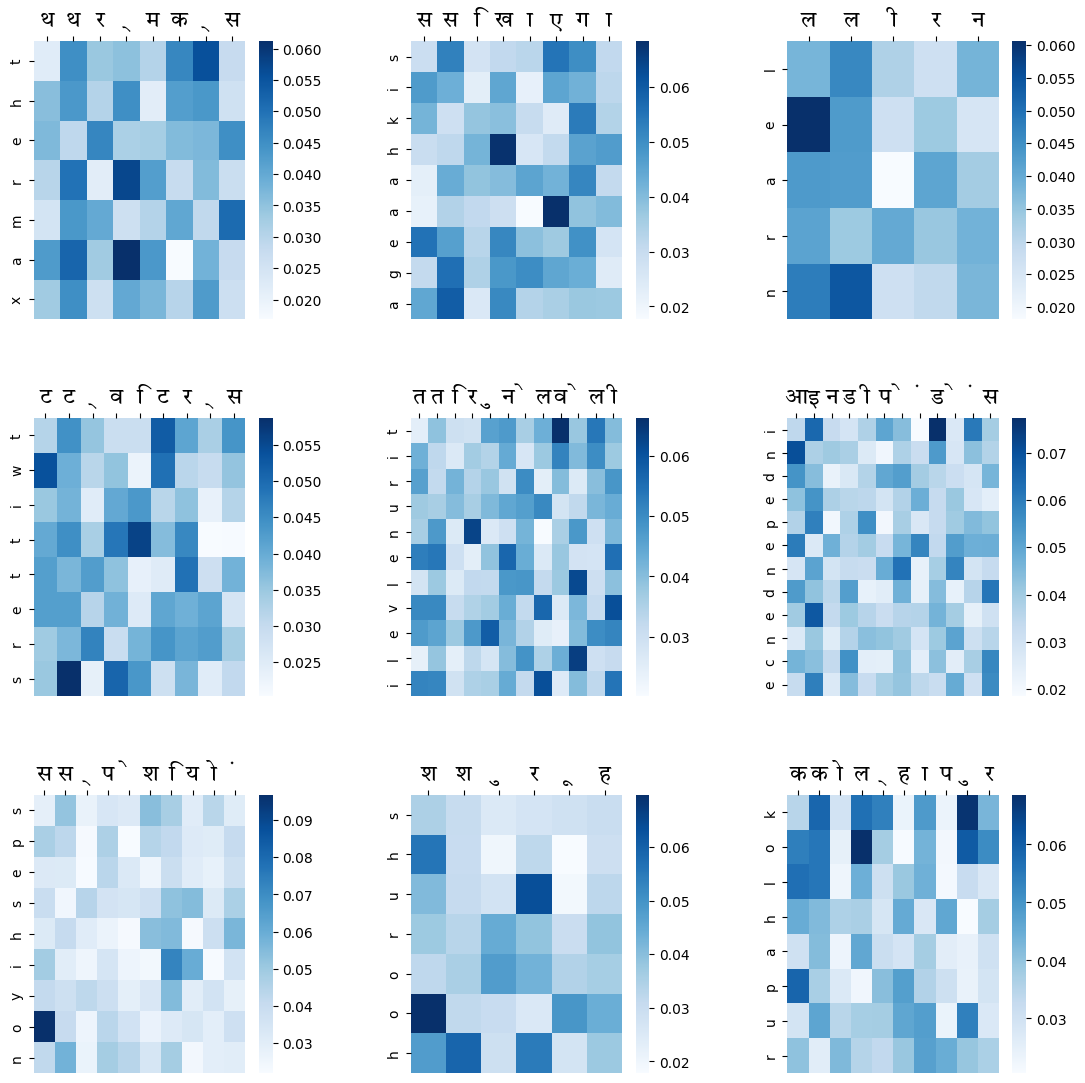

In [ ]:
# Create a figure with a 3x3 grid and set the size to 12x12 inches
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Adjust the spacing between subplots
fig.tight_layout(pad=5.0)

# Flatten the axes into a 1-dimensional array
axes = axes.ravel()

# Iterate over each index up to 9
for i in range(0,9):
    # Get the attention weights for the corresponding input word
    attn_weight = attn_weights[i].cpu().detach().numpy()
    attn_weight = attn_weight[1:len(input_w[i]) + 1,:len(output[i])]
    # Plot the attention weights as a heatmap on the current axis
    sns.heatmap(attn_weight, ax=axes[i], cmap='Blues')

    # Set the y-axis tick labels to the input words
    axes[i].set_yticklabels(input_w[i])

    # Set the x-axis tick labels to the output words
    axes[i].set_xticklabels(output[i], fontproperties=hindi_font, fontdict={'fontsize': 16})

    # Move the x-axis ticks to the top of the heatmap
    axes[i].xaxis.tick_top()



In [ ]:
!python train.py

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs22m076 (saisreeram). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /content/wandb/run-20230520_110639-k7oydsa8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wandering-silence-1
wandb: ⭐️ View project at https://wandb.ai/saisreeram/Assignment-031
wandb: 🚀 View run at https://wandb.ai/saisreeram/Assignment-031/runs/k7oydsa8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | encoder | AttnEncoder | 991 K 
1 | decoder | AttnDecoder | 1.1 M 
----------------------------------------
2.0 M    

In [ ]:
!python train.py -dp aksharantar_sampled/ -la hin -e 5 -b 128 -lr 0.0001 -cl GRU -bd True -at True -do 0.2 -el 3 -dl 3 -es 16 -hls 128


wandb: Currently logged in as: cs22m076 (saisreeram). Use `wandb login --relogin` to force relogin
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /content/wandb/run-20230520_113916-873v0pp5
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run atomic-mountain-2
wandb: ⭐️ View project at https://wandb.ai/saisreeram/Assignment-031
wandb: 🚀 View run at https://wandb.ai/saisreeram/Assignment-031/runs/873v0pp5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params
----------------------------------------
0 | encoder | AttnEncoder | 705 K 
1 | decoder | AttnDecoder | 762 K 
----------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.871    